# 1. Install Dependencies and Setup

In [67]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
appnope                      0.1.4
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.5.0
certifi                      2024.8.30
charset-normalizer           3.4.0
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.8
decorator                    5.1.1
exceptiongroup               1.2.2
executing                    2.1.0
flatbuffers                  24.3.25
fonttools                    4.54.1
gast                         0.4.0
google-auth                  2.36.0
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.67.1
h5py                         3.12.1
idna                         3.10
ipykernel                    6.29.5
ipython                      8.29.0
jedi                         0.19.1

In [68]:
import tensorflow as tf
import os

In [69]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [70]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [71]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [72]:
import cv2
import imghdr

In [73]:
data_dir = 'data' 

In [74]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [75]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

NotADirectoryError: [Errno 20] Not a directory: 'data/.DS_Store'

# 3. Load Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data')

In [ ]:
data_iterator = data.as_numpy_iterator()

In [76]:
batch = data_iterator.next() #batch has 2 dimension, labels(32,256,256,3) and images

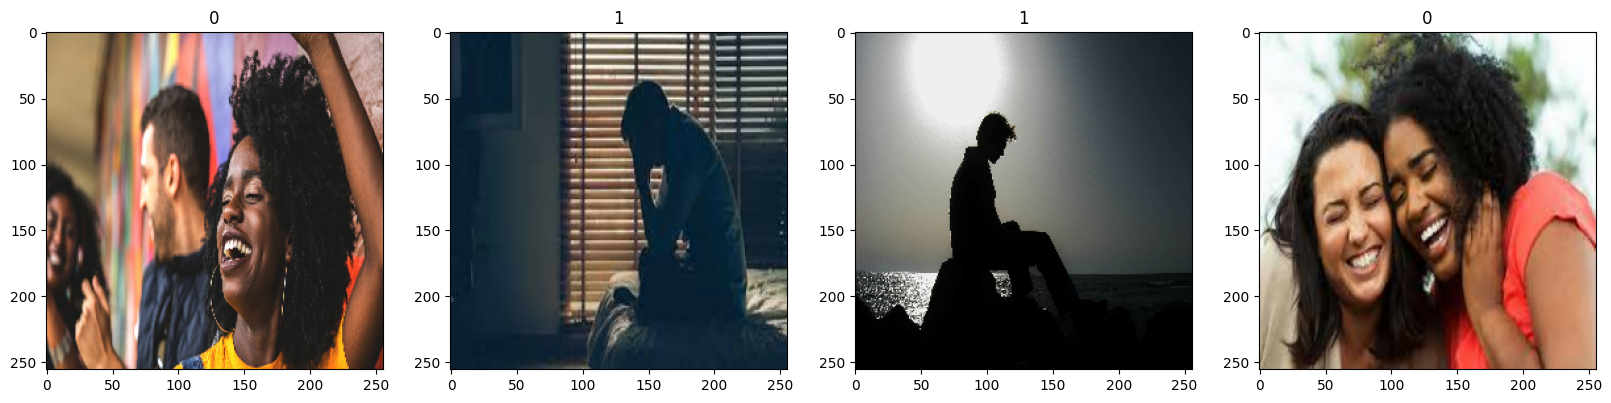

In [77]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [78]:
data = data.map(lambda x,y: (x/255, y))

In [79]:
data.as_numpy_iterator().next()

2024-11-10 11:35:04.382448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2024-11-10 11:35:04.384669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]


(array([[[[0.2528799 , 0.3313113 , 0.22542892],
          [0.22530638, 0.30373776, 0.19684437],
          [0.20784314, 0.28795955, 0.17310049],
          ...,
          [0.        , 0.07058824, 0.09803922],
          [0.        , 0.07349878, 0.09803922],
          [0.        , 0.07450981, 0.09803922]],
 
         [[0.25114363, 0.329575  , 0.22369266],
          [0.22579609, 0.30422747, 0.1978238 ],
          [0.20974265, 0.28904286, 0.1777157 ],
          ...,
          [0.        , 0.05919117, 0.08745835],
          [0.        , 0.06069192, 0.08664215],
          [0.        , 0.06468578, 0.08490589]],
 
         [[0.2460339 , 0.32336235, 0.21903962],
          [0.2238444 , 0.30117282, 0.19584195],
          [0.21011029, 0.28767568, 0.1804228 ],
          ...,
          [0.        , 0.04650735, 0.07540642],
          [0.        , 0.04650735, 0.07313974],
          [0.        , 0.05266831, 0.06876676]],
 
         ...,
 
         [[0.33858618, 0.45012543, 0.18838848],
          [0.36787

# 5. Split Data

In [80]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [81]:
train_size

7

In [82]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [83]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [84]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [85]:
model = Sequential()

In [86]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [87]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [89]:
logdir='logs'

In [90]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [91]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2024-11-10 11:35:15.030029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2024-11-10 11:35:15.031053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2024-11-10 11:35:15.550575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-10 11:35:15.635466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal n

7/7 [==============================] - ETA: 0s - loss: 1.2107 - accuracy: 0.5446

2024-11-10 11:35:19.394037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2024-11-10 11:35:19.394359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2024-11-10 11:35:19.460831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 447ms/step - loss: 1.2107 - accuracy: 0.5446 - val_loss: 0.7930 - val_accuracy: 0.4531
Epoch 2/20
7/7 [==============================] - 4s 418ms/step - loss: 0.6018 - accuracy: 0.6384 - val_loss: 0.5756 - val_accuracy: 0.7031
Epoch 3/20
7/7 [==============================] - 5s 428ms/step - loss: 0.5228 - accuracy: 0.7723 - val_loss: 0.4559 - val_accuracy: 0.8281
Epoch 4/20
7/7 [==============================] - 5s 431ms/step - loss: 0.4218 - accuracy: 0.8527 - val_loss: 0.5971 - val_accuracy: 0.6875
Epoch 5/20
7/7 [==============================] - 4s 415ms/step - loss: 0.3720 - accuracy: 0.8438 - val_loss: 0.2739 - val_accuracy: 0.9375
Epoch 6/20
7/7 [==============================] - 4s 385ms/step - loss: 0.2509 - accuracy: 0.9241 - val_loss: 0.2583 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 5s 454ms/step - loss: 0.2091 - accuracy: 0.9062 - val_loss: 0.1988 - val_accuracy: 0.9062
Epoch 8/20
7/7 [===============

# 8. Plot Performance

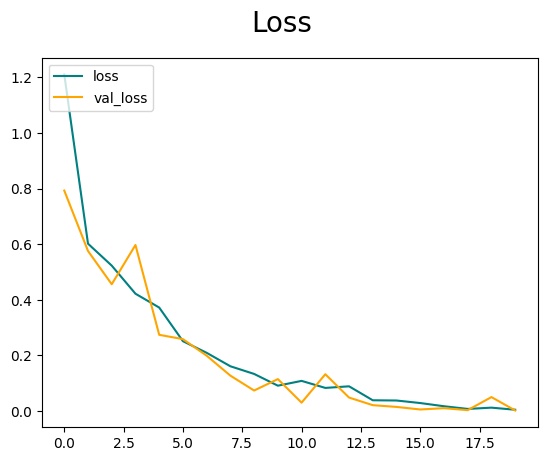

In [92]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

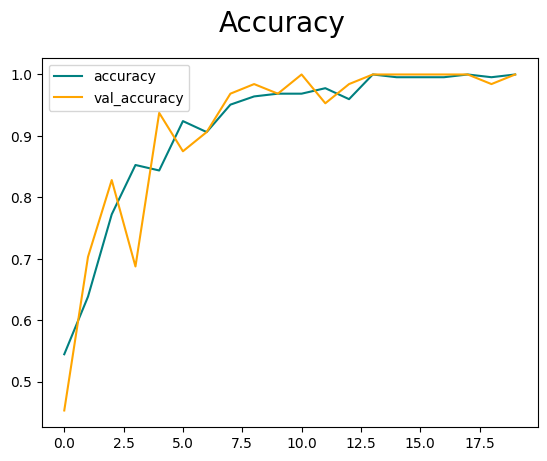

In [93]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [94]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [95]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [96]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2024-11-10 11:37:11.509139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2024-11-10 11:37:11.510638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2024-11-10 11:37:13.553820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 282ms/step


In [98]:
print(f'Precision: {pre.result()},Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 1.0,Recall: 1.0, Accuracy: 1.0


# 10. Test

In [61]:
import cv2

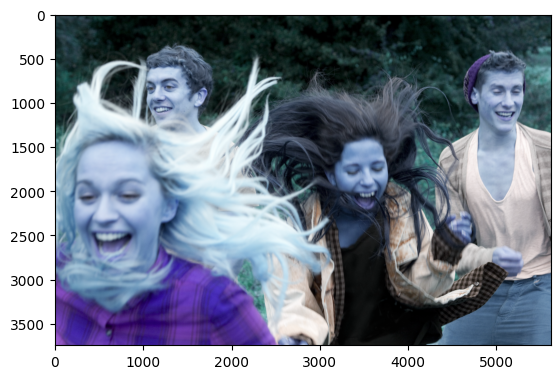

In [62]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

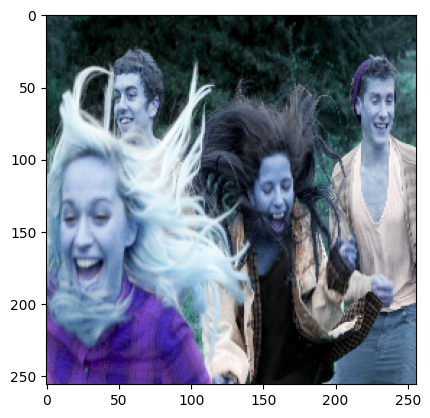

In [63]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [64]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 574ms/step


In [65]:
yhat

array([[0.42790365]], dtype=float32)

In [66]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)